In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tqdm
import torch
import time
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import nltk
from nltk.tokenize import WordPunctTokenizer
from sklearn import metrics
from bs4 import BeautifulSoup
import re,string,unicodedata
from IPython.display import clear_output


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
imdb_data=pd.read_csv('IMDB Dataset.csv')

In [4]:
gloveDict = {}
meanWordScore = np.zeros(200)
with open('imdbdata/glove.6B.200d.txt', 'r') as f:
    for line in tqdm.tqdm(f):
        lin = line.strip().split()
        vec = np.array(list(map(float, lin[1:])))
        gloveDict[lin[0]] = vec
        meanWordScore += vec
meanWordScore /= len(gloveDict)

400000it [00:17, 22753.01it/s]


In [5]:
def remove_tags(st):
    result = re.sub('<.*?>',' ',st)
    return result

In [6]:
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text) 
    return text

In [7]:
def sentence_to_glove(sent : list):
    return np.array(list(map(lambda x: gloveDict.get(x, meanWordScore), sent)))

In [8]:
wordPunctTokenizer = WordPunctTokenizer()

In [9]:
def word_to_idx_func():
    counter = 0
    word_to_idx = {}
    mapped_sentences = []
    for sentence in imdb_data['full_review_words']:
        sentence_ids = []
        for word in sentence:
            if word in word_to_idx:
                sentence_ids.append(word_to_idx[word])
            else:
                word_to_idx[word] = counter
                counter+=1
                sentence_ids.append(word_to_idx[word])
        
        mapped_sentences.append(sentence_ids) 
    imdb_data['full_review_words_idx'] = pd.Series(mapped_sentences).values
    return word_to_idx

In [10]:
imdb_data['sentiment'] = imdb_data['sentiment'].apply(lambda x: 1 if (x=="positive" or x==1) else 0)
imdb_data['full_review']= imdb_data['review'].apply(lambda cw : remove_tags(cw))
imdb_data['full_review_lower'] = imdb_data['full_review'].str.lower()
imdb_data['full_review_words'] = imdb_data['full_review_lower'].apply(wordPunctTokenizer.tokenize)
imdb_data['full_review_glove'] = imdb_data.full_review_words.apply(lambda x : sentence_to_glove(x))
imdb_data['full_review_words_special'] = imdb_data.full_review_lower.apply(lambda x : remove_special_characters(x))
word_to_idx = word_to_idx_func()

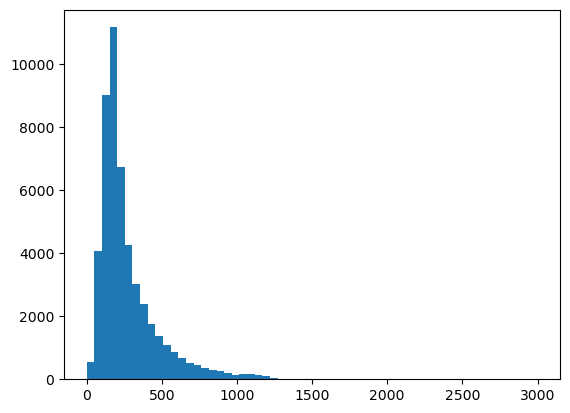

In [95]:
plt.hist(imdb_data.full_review_words_idx.apply(lambda x: len(x)), bins = np.linspace(0, 3000,60))
plt.show()

In [12]:
from sklearn.model_selection import train_test_split
random_state = np.random.RandomState(192)

In [13]:
train, test = train_test_split(imdb_data, test_size=0.3, random_state=random_state)

In [14]:
test.head()

,review,sentiment,full_review,full_review_lower,full_review_words,full_review_glove,full_review_words_special,full_review_words_idx
13310,"First of all, I ain't American or Middle-Easte...",0,"First of all, I ain't American or Middle-Easte...","first of all, i ain't american or middle-easte...","[first, of, all, ,, i, ain, ', t, american, or...","[[-0.14931, 0.39057, -0.44791, -0.5939, -0.296...",first of all i aint american or middleeastern ...,"[32, 1, 87, 23, 121, 3188, 15, 131, 2678, 56, ..."
30050,It used to be my thinking that movies required...,0,It used to be my thinking that movies required...,it used to be my thinking that movies required...,"[it, used, to, be, my, thinking, that, movies,...","[[0.21632, 0.21896, 0.12569, -0.17436, 0.17336...",it used to be my thinking that movies required...,"[68, 1329, 62, 17, 501, 972, 7, 582, 4441, 768..."
17308,After eight Moto films the series had run its ...,0,After eight Moto films the series had run its ...,after eight moto films the series had run its ...,"[after, eight, moto, films, the, series, had, ...","[[-0.53799, 0.31267, -0.50511, -0.65812, -0.31...",after eight moto films the series had run its ...,"[8, 3767, 60979, 664, 2, 553, 546, 1350, 37, 1..."
809,"Good Lord, what were they THINKING??!!!!!! Her...",0,"Good Lord, what were they THINKING??!!!!!! Her...","good lord, what were they thinking??!!!!!! her...","[good, lord, ,, what, were, they, thinking, ??...","[[0.51507, 0.35596, 0.1571, -0.074075, -0.2544...",good lord what were they thinking here is your...,"[478, 4720, 23, 28, 565, 20, 972, 16480, 658, ..."
44184,"OMG, it is seriously the best show in the worl...",1,"OMG, it is seriously the best show in the worl...","omg, it is seriously the best show in the worl...","[omg, ,, it, is, seriously, the, best, show, i...","[[0.52223, -0.017557, -0.37332, 0.067787, -0.4...",omg it is seriously the best show in the world...,"[15474, 23, 68, 26, 2291, 2, 470, 52, 45, 2, 4..."


### Bag of words and classical method

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

In [16]:
vec = TfidfVectorizer(stop_words='english')
x_train_trans = vec.fit_transform(train['full_review_words_special'])
x_test_trans=vec.transform(test['full_review_words_special'])

### Gradient boosting

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
parameters = {'n_estimators':[1000], 'max_depth':[1,2,4,6,8,10]}
rfc = RandomForestClassifier()
clf = GridSearchCV(rfc, parameters, verbose=0, error_score='raise', n_jobs=-1)
clf.fit(x_train_trans, train['sentiment'].values)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(error_score='raise', estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 4, 6, 8, 10],
                         'n_estimators': [1000]},
             verbose=4)

In [40]:
clf.best_estimator_

RandomForestClassifier(max_depth=10, n_estimators=1000)

In [41]:
predicted_test = clf.best_estimator_.predict(x_test_trans)

In [49]:
rf_accuracy = metrics.accuracy_score(test['sentiment'].values, predicted_test)
print(rf_accuracy)

0.8506


In [50]:
rf_f1 = metrics.f1_score(test['sentiment'].values, predicted_test)
print(rf_f1)

0.8533856722276743


### LSTM with trainable embeddings

In [52]:
class PadSequenceEmbed:
    def __call__(self, batch, maxlen=400):
        # each element in "batch" is a tuple (data, label).
        sequences = [torch.LongTensor(x[0])[:maxlen] for x in batch]
        sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)
        labels = torch.Tensor(list(map(lambda x: x[1], batch)))
        lengths = torch.LongTensor([len(x) for x in sequences])
        return sequences_padded, lengths, labels

In [53]:
dataloader_train_idx = DataLoader(list(train[['full_review_words_idx', 'sentiment']].itertuples(index=False, name = None)),
                                  batch_size=64, shuffle=True, collate_fn=PadSequenceEmbed())
dataloader_test_idx = DataLoader(list(test[['full_review_words_idx', 'sentiment']].itertuples(index=False, name = None)),
                                 batch_size=64, shuffle=True, collate_fn=PadSequenceEmbed())

In [54]:
class LSTMSentimentEmbed(nn.Module):
    def __init__(self, hidden_dim, vocab_size, embedding_dim=200, target_size=1):
        super().__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.hidden2tag = nn.Linear(hidden_dim, target_size)
        
    def forward(self, sentence, lengths):
        embeds = self.word_embeddings(sentence)
        output, _ = self.lstm(embeds)
        last_state = output[torch.arange(len(output)), lengths - 1]
        tag_space = self.hidden2tag(last_state).squeeze(-1)
        tag_scores = torch.sigmoid(tag_space)
        return tag_scores

In [55]:
lstm_model_embed = LSTMSentimentEmbed(hidden_dim=128, vocab_size=len(word_to_idx)).to(device)

In [56]:
optimizer_text = torch.optim.Adam(lstm_model_embed.parameters(), lr=0.001)
scheduler_text = torch.optim.lr_scheduler.ExponentialLR(optimizer_text, gamma=0.85)

In [57]:
def training(dataloader, model, optimizer, scheduler,  epochs_number = 30):
    loss = nn.BCELoss()

    epochs_number = 30
    losses = []
    running_loss = 0.
    last_loss = 0.

    model.train()
    start_time = time.time()

    for epoch in range(epochs_number):
        running_loss = 0.
        epoch_start_time = time.time()
        print('Epoch : {}'.format(epoch+1))

        trainLoss = 0.
        correct = 0
        train_losses_epoch = []
        for ii, data in enumerate(dataloader):

            train_features, lengths, train_labels = data
            optimizer.zero_grad()

            X_pred = model(train_features.to(device), lengths.to(device))
            bceloss = loss(X_pred, train_labels.to(device))
            bceloss.backward()
            optimizer.step()
            running_loss += bceloss.item()
        losses.append(running_loss / len(dataloader))
        clear_output(wait=True)
        plt.plot(np.array(losses))
        plt.show()
        print(running_loss / len(dataloader))
        scheduler.step()

    print(f'\nDuration: {time.time() - start_time:.0f} seconds')
    return losses


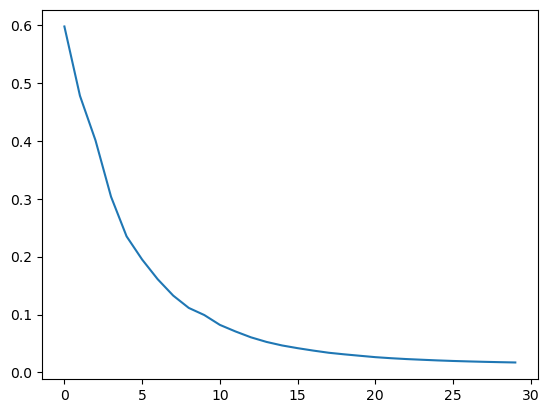

0.017251855122109354

Duration: 406 seconds


In [46]:
losses = training(dataloader_train_idx, lstm_model_embed, optimizer_text, scheduler_text)

In [60]:
from sklearn import metrics

def validation(dataloader, model, skmetrics = (metrics.f1_score, metrics.accuracy_score)):
    model.eval()
    loss = nn.BCELoss()
    predictions = []
    labels = []
    metrics_dict = {}

    with torch.no_grad(): 
        running_loss = 0.
        running_acc = 0.
        for ii, data in enumerate(dataloader):

            train_features, lengths, train_labels = data

            X_pred = model(train_features.to(device), lengths.to(device))
            predictions.extend((X_pred.cpu() > 0.5).numpy().tolist())
            labels.extend(train_labels.numpy().tolist())
            bceloss = loss(X_pred, train_labels.to(device))
            running_loss += bceloss.item()

        mean_loss = running_loss / len(dataloader)
        print("loss:",mean_loss)
        labels = np.array(labels)
        predictions = np.array(predictions)
        
        for metr in skmetrics:
            metrics_dict[metr.__name__] = metr(labels, predictions)
        print(metrics_dict)

    return mean_loss, metrics_dict

In [61]:
mean_loss_emb_train, metrics_emb_train = validation(dataloader_train_idx,lstm_model_embed)

loss: 0.016791594172172398
{'f1_score': 0.99584729501389, 'accuracy_score': 0.9958571428571429}


In [62]:
mean_loss_emb_test, metrics_emb_test = validation(dataloader_test_idx,lstm_model_embed)

loss: 0.5644659776636894
{'f1_score': 0.8799307036247335, 'accuracy_score': 0.8798666666666667}


In [66]:
#torch.save(lstm_model_embed.state_dict(), "LSTM_embed.pt")

In [59]:
#lstm_model_embed.load_state_dict(torch.load("LSTM_embed.pt"))

<All keys matched successfully>

We see that the test loss is much higher, and we have 88% accuracy

### LSTM with glove

In [63]:
class PadSequence:
    def __call__(self, batch, maxlen=400):
        # each element in "batch" is a tuple (data, label).
        sequences = [torch.FloatTensor(x[0])[:maxlen] for x in batch]
        sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)
        labels = torch.Tensor(list(map(lambda x: x[1], batch)))
        lengths = torch.LongTensor([len(x) for x in sequences])
        return sequences_padded, lengths, labels

In [64]:
dataloader_train_glove = DataLoader(list(train[['full_review_glove', 'sentiment']].itertuples(index=False, name = None)),
                                    batch_size=64, shuffle=True, collate_fn=PadSequence())
dataloader_test_glove = DataLoader(list(test[['full_review_glove', 'sentiment']].itertuples(index=False, name = None)),
                                   batch_size=64, shuffle=True, collate_fn=PadSequence())

In [65]:
class LSTMSentiment(nn.Module):
    def __init__(self, hidden_dim, embedding_dim=200, target_size=1):
        super(LSTMSentiment, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.hidden2tag = nn.Linear(hidden_dim, target_size)
        
    def forward(self, embeds_in_review, lengths):
        output, _ = self.lstm(embeds_in_review)
        last_state = output[torch.arange(len(output)), lengths - 1]
        tag_space = self.hidden2tag(last_state).squeeze(-1)
        tag_scores = torch.sigmoid(tag_space)
        return tag_scores

In [66]:
lstm_model = LSTMSentiment(128).to(device)
optimizer_text = torch.optim.Adam(lstm_model.parameters(), lr=0.001)
scheduler_text = torch.optim.lr_scheduler.ExponentialLR(optimizer_text, gamma=0.85)

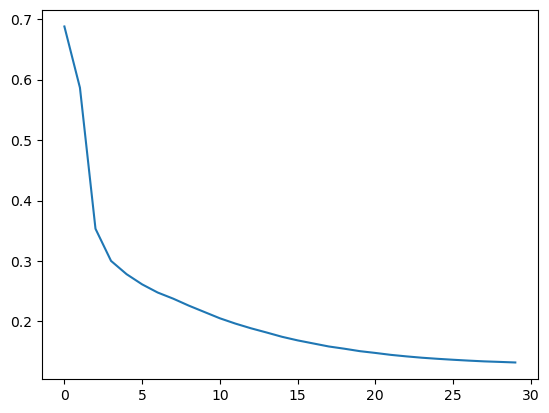

0.1321176792983599

Duration: 329 seconds


In [35]:
losses = training(dataloader_train_glove, lstm_model, optimizer_text, scheduler_text)

In [68]:
mean_loss_glove_train, metrics_glove_train = validation(dataloader_train_glove,lstm_model)

loss: 0.13106707015314856
{'f1_score': 0.9531641247439109, 'accuracy_score': 0.9529714285714286}


In [69]:
mean_loss_glove, metrics_glove = validation(dataloader_test_glove,lstm_model)

loss: 0.310593178139088
{'f1_score': 0.8880324274038143, 'accuracy_score': 0.8876666666666667}


In [40]:
#torch.save(lstm_model.state_dict(), "LSTM_glove.pt")

In [67]:
#lstm_model.load_state_dict(torch.load("LSTM_glove.pt"))

<All keys matched successfully>

After the same amount of training with the same learning rate, glove model attained higher training loss and lower training accuracy, but lower test loss and slightly higher test accuracy. It is reasonable result. From one hand, model with less parameters is less prone to overfitting. From the other hand, embeddings pretrained from a large text corpus are more generalizable.

## Transfer Learning

In [42]:
#using hugging face libraries (uncomment to install)
#!pip install 'transformers[torch]'
#!pip install datasets
#!pip install evaluate

In [70]:
import torch
from datasets import Dataset
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification

In [71]:
imdb_data_hugg = pd.read_csv('IMDB Dataset.csv')
imdb_data_hugg.columns = ["text", "label"]
imdb_data_hugg['label'] = imdb_data_hugg['label'].apply(lambda x: 1 if (x=="positive" or x==1) else 0)


In [72]:
random_state = np.random.RandomState(192)
imdb_dataset = Dataset.from_pandas(imdb_data_hugg)
imdb_dataset_spl = imdb_dataset.train_test_split(test_size=0.3,generator=random_state) ##same split as for LSTM

In [73]:
# Define the evaluation metrics 
import numpy as np
from datasets import load_metric

def compute_metrics(eval_pred):
    load_accuracy = load_metric("accuracy")
    load_f1 = load_metric("f1")
    
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"accuracy": accuracy, "f1": f1}

### DistilBERT

In [74]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [75]:
# Prepare the text inputs for the model
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True)

tokenized_train = imdb_dataset_spl["train"].map(preprocess_function, batched=True)
tokenized_test = imdb_dataset_spl["test"].map(preprocess_function, batched=True)

Map:   0%|          | 0/35000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

In [76]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2, device_map='cuda')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [77]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [78]:
repo_name = "finetuning-distilbert"

training_args = TrainingArguments(
    output_dir=repo_name,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01, ##corresponds to original model
    save_strategy="epoch", 
    push_to_hub=False,
    report_to=[],
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [37]:
# Train the model
trainer.train()
##we stopped after ~3 epochs

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.319300
1000,0.237900
1500,0.224800
2000,0.212500
2500,0.167500
3000,0.149000
3500,0.143000
4000,0.128100
4500,0.136100
5000,0.075000


KeyboardInterrupt: 

In [91]:
# Compute the evaluation metrics
distilbert_metrics = trainer.evaluate()


In [90]:
distilbert_metrics

{'eval_loss': 0.2953391373157501,
 'eval_accuracy': 0.9344666666666667,
 'eval_f1': 0.9346105235149338,
 'eval_runtime': 175.0545,
 'eval_samples_per_second': 85.688,
 'eval_steps_per_second': 5.358}

In [39]:
#torch.save(model.state_dict(), "distilbert.pt")

In [79]:
#model.load_state_dict(torch.load("distilbert.pt"))

<All keys matched successfully>

### RoBERTa

In [81]:
model = None
torch.cuda.empty_cache()  ##free gpu memory, we'll need it

In [82]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

In [83]:
# Prepare the text inputs for the model
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True)

tokenized_train = imdb_dataset_spl["train"].map(preprocess_function, batched=True)
tokenized_test = imdb_dataset_spl["test"].map(preprocess_function, batched=True)

Map:   0%|          | 0/35000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

In [84]:
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2, device_map='cuda')

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [85]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [86]:
repo_name = "finetuning-roberta"

training_args = TrainingArguments(
    output_dir=repo_name,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    weight_decay=0.01, ##corresponds to original model
    save_strategy="epoch", 
    push_to_hub=False,
    report_to=[],
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [56]:
trainer.train()

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.237900
1000,0.171400
1500,0.122300
2000,0.112000
2500,0.087700
3000,0.069400


TrainOutput(global_step=3279, training_loss=0.12801954520115877, metrics={'train_runtime': 5559.7236, 'train_samples_per_second': 18.886, 'train_steps_per_second': 0.59, 'total_flos': 2.760771681681408e+16, 'train_loss': 0.12801954520115877, 'epoch': 3.0})

In [88]:
roberta_metrics = trainer.evaluate()

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [89]:
roberta_metrics

{'eval_loss': 0.17199577391147614,
 'eval_accuracy': 0.9568666666666666,
 'eval_f1': 0.9573528442423043,
 'eval_runtime': 317.7496,
 'eval_samples_per_second': 47.207,
 'eval_steps_per_second': 5.901}

In [58]:
#torch.save(model.state_dict(), "roberta.pt")

In [87]:
#model.load_state_dict(torch.load("roberta.pt"))

<All keys matched successfully>

After similar amount of training epochs (though with approximately twice the computational resources), Roberta shows better generalization than distilbert. With the comparable training loss, eval loss is substantially lower, and accuracy is 95.7%, compared to 93.4% from distilbert. I didn't try to find the optimal stopping parameters and just tuned the models for a few epochs.

In [92]:
metrics_dict = {'model' : ['Tf-Idf + RandomForest', 'LSTM', 'LSTM+glove', 'DistilBERT', 'RoBERTa'],
        'accuracy' : [rf_accuracy, metrics_emb_test['accuracy_score'], metrics_glove['accuracy_score'], 
                      distilbert_metrics['eval_accuracy'], roberta_metrics['eval_accuracy']],
        'f1_score' : [rf_f1, metrics_emb_test['f1_score'], metrics_glove['f1_score'], 
                      distilbert_metrics['eval_f1'], roberta_metrics['eval_f1']]}

In [93]:
pd.DataFrame(metrics_dict)

,model,accuracy,f1_score
0,Tf-Idf + RandomForest,0.850600,0.853386
1,LSTM,0.879867,0.879931
2,LSTM+glove,0.887667,0.888032
3,DistilBERT,0.934467,0.934611
4,RoBERTa,0.956867,0.957353
